## 获得股票数据

In [1]:
import pandas as pd
import numpy as np
import akshare as ak

# 读入5支股票 2019-01-01 到 2023-12-31日收盘价数据
def get_close(code):
    data = ak.stock_zh_a_hist(symbol=code, period='daily', start_date='20190101', end_date='20231231', adjust='')
    data.index = pd.to_datetime(data['日期'],format='%Y-%m-%d') #设置日期索引
    close = data['收盘'] #日收盘价
    close.name = code
    return close

codes=['000001','000651','300015','002156','000625']
df = pd.DataFrame()
for code in codes:
    df_ = get_close(code)
    df = pd.concat([df,df_],axis=1)
df = df.dropna()

D:\anaconda3\lib\site-packages\akshare\__init__.py:2681: UserWarning: 为了支持更多特性，请将 Pandas 升级到 2.1.0 及以上版本！
  warnings.warn(


Text(0, 0.5, 'Close')

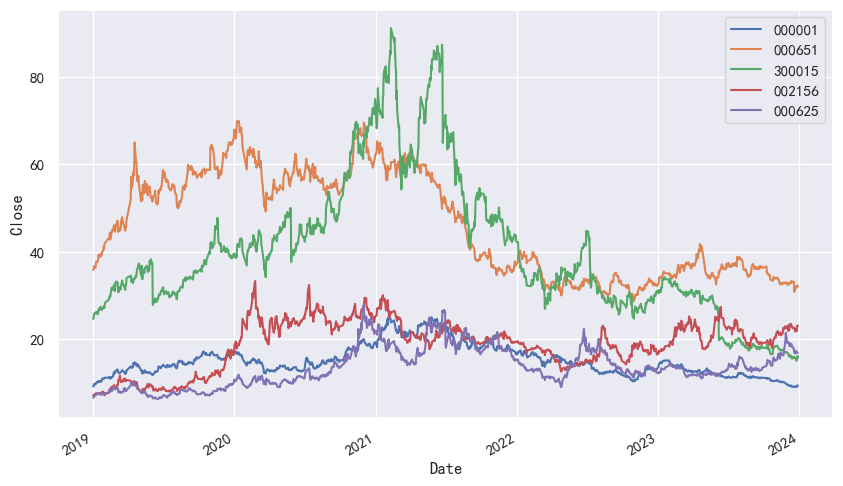

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='SimHei')     # 设置字体
plt.rcParams['axes.unicode_minus'] = False  #正常显示负号
ax = df.plot(figsize=(10,6))
ax.set_xlabel('Date',fontsize=12)  
ax.set_ylabel('Close',fontsize=12)  


Text(0, 0.5, 'Pct Change')

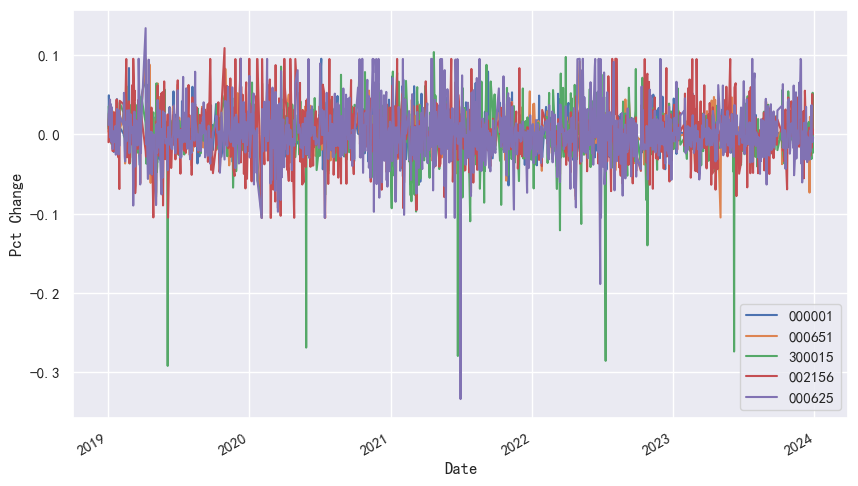

In [3]:
import numpy as np
returns_day=np.log(df/df.shift(1))          #计算日度收益率
returns_day.dropna(inplace=True)            #删除空值

#绘制日收益率波动图
ax_v = returns_day.plot(figsize=(10,6))
ax_v.set_xlabel('Date',fontsize=12)  # x轴标注
ax_v.set_ylabel('Pct Change',fontsize=12)  # y轴标注


In [4]:
returns_annual = returns_day.mean()*252 #计算年化收益率
returns_annual

000001    0.004517
000651   -0.022433
300015   -0.092802
002156    0.245955
000625    0.195781
dtype: float64

In [5]:
cov_annual = returns_day.cov()*252 #计算协方差
cov_annual

,000001,000651,300015,002156,000625
000001,0.107292,0.043978,0.041798,0.023851,0.038011
000651,0.043978,0.088608,0.039730,0.024474,0.041119
300015,0.041798,0.039730,0.261478,0.031847,0.051089
002156,0.023851,0.024474,0.031847,0.266833,0.060916
000625,0.038011,0.041119,0.051089,0.060916,0.311075


## 最小方差组合


In [6]:
rf = 0.02
# 给定权重，求组合收益率、标准差、夏普比率
def statistics(weights):        
    weights = np.array(weights)
    port_returns = np.dot(weights, returns_annual)                            #获取组合收益率
    port_stdev = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))      #获取组合标准差
    port_sharpe = (port_returns - rf) / port_stdev                            #获取组合夏普比率
    return np.array([port_returns, port_stdev, port_sharpe])

In [7]:
import scipy.optimize as sco

# 定义规划求解目标函数：标准差进行最小化
def port_vol(weights): 
    return statistics(weights)[1]

num_assets = len(cov_annual)
# 约束条件：权重之和为1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# 目标函数输入参数（即权重）取值范围为0-1
bounds = tuple((0, 1) for x in range(num_assets))
min_vol_port = sco.minimize(port_vol, num_assets*[1./num_assets,],
                     method='SLSQP', bounds=bounds, constraints=constraints)
min_vol_port_weights = min_vol_port.x                                      # 最小方差组合各资产权重
min_vol_port_statisitcs = statistics(min_vol_port_weights)                 # 最小方差组合的收益、标准差、夏普比率
min_vol_port_allocation = pd.DataFrame(min_vol_port_weights,index=cov_annual.columns,columns=['最小方差组合配置比例'])   # 最小方差组合配置表格
min_vol_port_allocation = min_vol_port_allocation.applymap(lambda x:format(x,'.2%'))                 #设置数据格式为百分比两位数
print(min_vol_port_allocation)


       最小方差组合配置比例
000001     29.74%
000651     42.05%
300015      8.84%
002156     13.40%
000625      5.96%


In [8]:

tag = ['收益率','标准差','夏普比率']
for i in range(len(tag)):
    print(f'最小方差组合{tag[i]}:{min_vol_port_statisitcs[i]:.1%}')

最小方差组合收益率:2.8%
最小方差组合标准差:24.4%
最小方差组合夏普比率:3.4%


<AxesSubplot:>

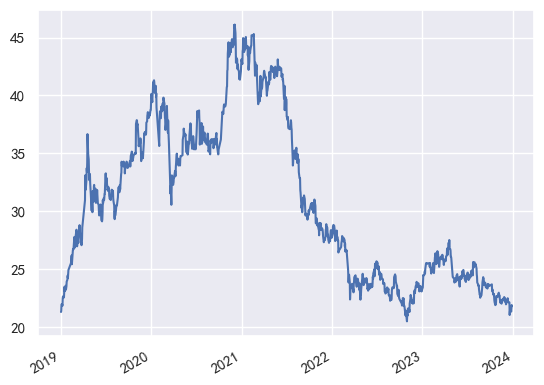

In [9]:
(df*min_vol_port_weights).sum(axis=1).plot()

## 最大夏普比率


In [10]:
# 定义规划求解目标函数：负的夏普比率进行最小化
def neg_sharpe_ratio(weights): 
    return -statistics(weights)[2]

num_assets = len(cov_annual)
# 约束条件：权重之和为1 
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# 目标函数输入参数（即权重）取值范围为0-1
bounds = tuple((0, 1) for x in range(num_assets))
max_sharpe_port = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], 
                    method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_port_weights = max_sharpe_port.x                                        # 最大夏普比率组合各资产权重
max_sharpe_port_statisitcs = statistics(max_sharpe_port_weights)                   # 最大夏普比率组合的收益、标准差、夏普比率
max_sharpe_port_allocation = pd.DataFrame(max_sharpe_port_weights,index=cov_annual.columns,columns=['最大夏普比率组合配置比例'])   # 最大夏普比率组合配置表格
max_sharpe_port_allocation = max_sharpe_port_allocation.applymap(lambda x:format(x,'.2%'))                 #设置数据格式为百分比两位数
print(max_sharpe_port_allocation)

       最大夏普比率组合配置比例
000001        0.00%
000651        0.00%
300015        0.00%
002156       64.24%
000625       35.76%


In [11]:
tag = ['收益率','标准差','夏普比率']
for i in range(len(tag)):
    print(f'最大夏普比率组合{tag[i]}:{max_sharpe_port_statisitcs[i]:.1%}')

最大夏普比率组合收益率:22.8%
最大夏普比率组合标准差:42.2%
最大夏普比率组合夏普比率:49.3%


<AxesSubplot:>

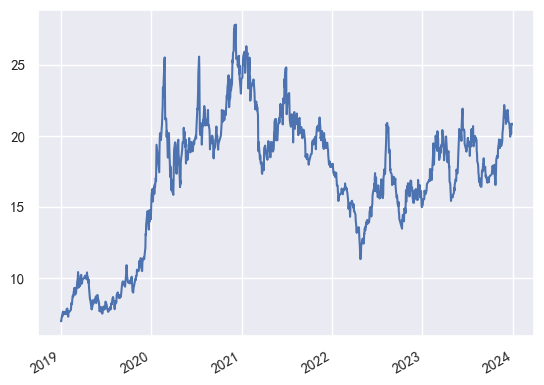

In [12]:
(df*max_sharpe_port_weights).sum(axis=1).plot()

## 随机模拟组合

In [13]:
#随机生成1000个投资组合
port_returns_list = []                  # 定义列表，存放组合年化收益率       
port_stdev_list = []                    # 定义列表，存放组合年化标准差
num_assets =len(cov_annual)        # 组合中的资产数
for x in range(5000):  
    #设置不同的随机种子，生成和为1的权重
    np.random.seed(x)
    weights = np.random.random(num_assets)     
    weights /= np.sum(weights)      
    port_returns = np.sum(weights*returns_annual)                              # 组合年化期望收益率
    port_stdev = np.sqrt(np.dot(weights.T ,np.dot(cov_annual ,weights)))       # 组合年化标准差
    port_returns_list.append(port_returns)    
    port_stdev_list.append(port_stdev)

port_returns = np.array(port_returns_list)
port_stdev = np.array(port_stdev_list)

port_returns_stdev = pd.DataFrame({'组合收益率':port_returns_list,'组合标准差':port_stdev_list})
port_returns_stdev = port_returns_stdev.applymap(lambda x:format(x,'.2%'))                 #设置数据格式为百分比两位数
port_returns_stdev.head()

,组合收益率,组合标准差
0,5.20%,26.28%
1,5.60%,25.02%
2,7.48%,29.95%
3,8.81%,28.18%
4,5.49%,27.37%


In [14]:
import scipy.optimize as sco

# 定义规划求解目标函数：标准差进行最小化
def port_vol(weights): 
    return statistics(weights)[1]

# 规划求解：给定收益，求最小标准差
# target_returns = np.linspace(min_vol_port_statisitcs[0],0.09,500)      # 定义不同目标收益率水平,最小为最小方差组合收益率
target_returns = np.linspace(0,0.2,500)      # 定义不同目标收益率水平,最小为最小方差组合收益率

target_min_stdev = []

#初始值x0：
num_assets = len(cov_annual)
x0 = num_assets*[1./num_assets,]
for tar in target_returns:
    #两个约束条件：（1）权重之和为1 （2）给定目标收益率
    constraints = [{'type':'eq','fun':lambda x: sum(x)-1},{'type':'eq','fun': lambda x:statistics(x)[0]-tar}] 
    #目标函数输入参数（即权重）取值范围为0-1
    bounds = tuple((0, 1) for x in range(num_assets))
    outcome = sco.minimize(port_vol,x0 = x0,method = 'SLSQP',constraints = constraints,bounds = bounds) #求解
    target_min_stdev.append(outcome.fun)         #将最小标准差合并到列表中

target_min_stdev = np.array(target_min_stdev)

port_returns_min_stdev = pd.DataFrame({'组合收益率':target_returns,'组合最小标准差':target_min_stdev})
port_returns_min_stdev = port_returns_min_stdev.applymap(lambda x:format(x,'.2%'))                 #设置数据格式为百分比两位数
port_returns_min_stdev.head()

,组合收益率,组合最小标准差
0,0.00%,24.83%
1,0.04%,24.82%
2,0.08%,24.81%
3,0.12%,24.80%
4,0.16%,24.78%


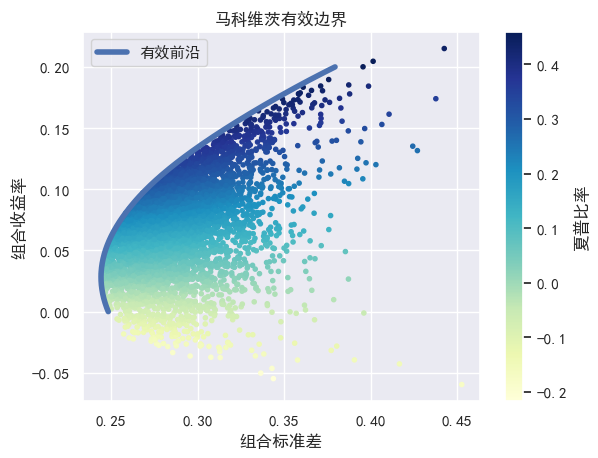

In [15]:
plt.scatter(port_stdev,port_returns,c=(port_returns-rf)/port_stdev,marker='.',cmap='YlGnBu')              # 1000个随机组合
plt.plot(target_min_stdev,target_returns,label='有效前沿',linewidth=4)      # 给定收益，方差最小的组合

plt.xlabel('组合标准差')
plt.ylabel('组合收益率')
plt.title('马科维茨有效边界')

plt.colorbar(label='夏普比率')
plt.legend()
plt.show()

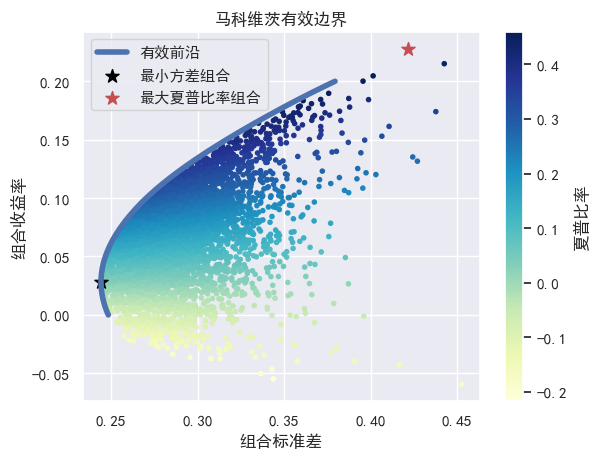

In [16]:
plt.scatter(port_stdev,port_returns,c=(port_returns-rf)/port_stdev,marker='.',cmap='YlGnBu')              # 1000个随机组合
plt.plot(target_min_stdev,target_returns,label='有效前沿',linewidth=4)      # 给定收益，方差最小的组合

plt.xlabel('组合标准差')
plt.ylabel('组合收益率')
plt.title('马科维茨有效边界')
plt.plot()
plt.colorbar(label='夏普比率')

# 黄星：标记最小方差组合
plt.scatter(min_vol_port_statisitcs[1],min_vol_port_statisitcs[0],color='black',marker='*',s=100,label='最小方差组合')
# 红星： 标记最大夏普比率组合
plt.scatter(max_sharpe_port_statisitcs[1],max_sharpe_port_statisitcs[0],color='r',marker='*',s= 100,label='最大夏普比率组合')

plt.legend()
plt.show()